<a href="https://colab.research.google.com/github/PJL-Emily/edamame/blob/main/GeneticAlgoVal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/weilao_research/毛豆

/content/drive/Shareddrives/weilao_research/毛豆


## Import Libraries and Data Sets

In [ ]:
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
def str2date(s):
  m = s[0: s.find('/')]
  if (len(m) < 2):
    m = '0'+m
  s = s[s.find('/')+1: ]
  d = s[0: s.find('/')]
  if (len(d) < 2):
    d = '0'+d
  y = s[s.find('/')+1: ]
  return y + '/' + m + '/' + d

In [ ]:
def hour2date(s):
  s = s[0: s.find(' ')]
  if (s.find('/') != 4):
    # print(s)
    # return s
    s = str2date(s)
    s = '20'+s
  # add 0
  y = s[0: s.find('/')]
  s = s[s.find('/')+1: ]
  m = s[0: s.find('/')]
  if (len(m) < 2):
    m = '0'+m
  d = s[s.find('/')+1: ]
  if (len(d) < 2):
    d = '0'+d
  date =  y + '/' + m + '/' + d
  # return date
  return datetime.strptime(date, '%Y/%m/%d').date()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


min = 5.6 , max = 37.4


(array([   37.,   220.,  1726.,  4475.,  6197., 10344., 16899.,  9238.,
         4466.,   480.]),
 array([ 5.6 ,  8.78, 11.96, 15.14, 18.32, 21.5 , 24.68, 27.86, 31.04,
        34.22, 37.4 ]),
 <a list of 10 Patch objects>)

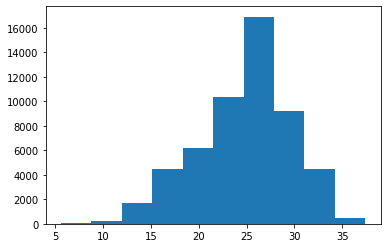

In [ ]:
# read the data: AirTemp
hourlyAirTemp = pd.read_csv('高改場逐時氣溫.csv')
hourlyAirTemp = hourlyAirTemp.rename(columns={' AirTemp': 'AirTemp'})
hourlyAirTemp['Date'] = hourlyAirTemp['DateTime'].apply(lambda s: hour2date(s))
dates = np.array(hourlyAirTemp['Date'])
airTemp = np.array(hourlyAirTemp['AirTemp'])
print('min =', np.array(hourlyAirTemp['AirTemp']).min(), ', max =', np.array(hourlyAirTemp['AirTemp']).max())
plt.hist(hourlyAirTemp['AirTemp'])

In [ ]:
# df = pd.DataFrame(dates, columns=["date"])
# df["temp"] = airTemp
# display(df)
# for i in range(len(dates)):
  # if (df["date"][i] >= datetime(2020, 4, 29).date() and df["date"][i] <= datetime(2020, 10, 5).date()):
  #   print(df["date"][i], df["temp"][i])
  # if ()

In [ ]:
# read the data: GrowthSamples
growthSamples = pd.read_csv('毛豆生長樣本.csv')
growthSamples['定植日'] = growthSamples['定植日'].apply(lambda s: datetime.strptime(str2date(s), '%Y/%m/%d').date())
growthSamples['開花日'] = growthSamples['開花日'].apply(lambda s: datetime.strptime(str2date(s), '%Y/%m/%d').date())
growthSamples['採收日'] = growthSamples['採收日'].apply(lambda s: datetime.strptime(str2date(s), '%Y/%m/%d').date())
# growthSamples = growthSamples[['定植日', '開花日', '採收日']]
# growthSamples = growthSamples.rename(columns={'定植日': 'plant_date', '開花日': 'bloom_date', '採收日': 'harvest_date'})
# display(growthSamples)
plantDates = np.array(growthSamples['定植日'])
bloomDates = np.array(growthSamples['開花日'])
harvestDates = np.array(growthSamples['採收日'])
# print(plant_date, harvest_date)
for i in range(plantDates.size):
  if (bloomDates[i] == datetime(2020, 3, 24).date()):
    plantDates = np.delete(plantDates, i)
    bloomDates = np.delete(bloomDates, i)
    harvestDates = np.delete(harvestDates, i)
    print(plantDates.size, bloomDates.size, harvestDates.size)
    break
for i in range(plantDates.size):
  if (bloomDates[i] == datetime(2021, 3, 15).date()):
    plantDates = np.delete(plantDates, i)
    bloomDates = np.delete(bloomDates, i)
    harvestDates = np.delete(harvestDates, i)
    print(plantDates.size, bloomDates.size, harvestDates.size)
    break

24 24 24
23 23 23


## Functions for Genetic Algorithm

In [ ]:
# const parameters
# WARNING: NEVER change their values
GENE_SIZE = 4
LOW_TEMP = airTemp.min()
UP_TEMP = airTemp.max()

In [ ]:
def generate_chromosome(gen_size):
  chromosomes = []
  for i in range(gen_size):
    chromo = []
    for j in range(GENE_SIZE):
      chromo.append(random.uniform(LOW_TEMP, UP_TEMP))
    chromo.sort()
    chromosomes.append(chromo)
  return chromosomes

In [ ]:
def computeCumuGrowth(chromo, DATE_SET, mute=True): # DATE_SET = [plantDates, harvestDates]
  CGs = []
  # each chromo is a set of temp = [t1, t2, t3, t4]
  for i in range(DATE_SET[0].size): # compute cumu_growth for each sample
    cumuGrowth = 0
    for j in range(airTemp.size): # compute cumu_growth of every hour
      if (dates[j] >= DATE_SET[0][i] and dates[j] <= DATE_SET[1][i]):
        growth = 0
        if airTemp[j] > chromo[0] and airTemp[j] < chromo[3]:
          if airTemp[j] < chromo[1]:
            growth = (airTemp[j] - chromo[0]) / (chromo[1] - chromo[0])
          elif airTemp[j] > chromo[2]:
            growth = (chromo[3] - airTemp[j]) / (chromo[3] - chromo[2])
          else:
            growth = 1
        cumuGrowth += growth
    CGs.append(cumuGrowth)
  if not mute:
    print(CGs)
  return CGs

In [ ]:
def fitness(chromo, DATE_SET):
  cg_list = computeCumuGrowth(chromo, DATE_SET)
  if (min(cg_list) == 0):
    return 0 # it's impossible that cumu_growth=0 in any sample
  fitness = np.mean(cg_list) / np.std(cg_list, ddof=1)
  return fitness

In [ ]:
def genetic_algorithm(training_set, generation_size=100, crossover_rate=0.85, mutation_rate=0.1, generation_limit=30, mute=False, plot=True): # fitness_limit: unspecified
  best_fit = 0
  best_chromo = []
  chromo_rec = []
  records = []
  avg_rec = []

  # Generate the initial population (generation_size, 4)
  chromosomes = generate_chromosome(generation_size)

  # while (!converge): # converge: no significant difference between the fitness of parents and that of children 
  for gen_cnt in tqdm(range(generation_limit-1)): # Timeout method
    chromo_rec.append([])
    # Compute fitness
    fit_of_gen = []
    for c in chromosomes:
      chromo_rec[gen_cnt].append(c)
      fit = fitness(c, training_set)
      fit_of_gen.append(fit)
      if fit > best_fit:
        best_fit = fit
        best_chromo = c
    records.append(max(fit_of_gen))
    avg_rec.append(sum(fit_of_gen)/len(fit_of_gen))
    
    # Selection and Crossover
    # softmax
    prob_dist = np.exp(fit_of_gen) / np.sum(np.exp(fit_of_gen))
    for i in range(len(chromosomes)):
      # decide the operation type (crossover / replicate) on chromo[i] 
      if random.random() < crossover_rate:
        another_parent = np.random.choice(generation_size, 1, p=prob_dist)[0]
        while (i == another_parent):
          another_parent = np.random.choice(generation_size, 1, p=prob_dist)[0]
        # crossover
        chromosomes[i] = list(np.array(chromosomes[i]) * 0.5 + np.array(chromosomes[another_parent]) * 0.5)
    
    # Mutation
    for c in chromosomes:
      for i in range(GENE_SIZE):
        if random.random() < mutation_rate:
          if (i == 0):
            c[i] = random.uniform(LOW_TEMP, c[i+1])
          elif (i == GENE_SIZE-1):
            c[i] = random.uniform(c[i-1], UP_TEMP)
          else:
            c[i] = random.uniform(c[i-1], c[i+1])

  # Compute fitness of the last generation
  fit_of_gen = []
  last_best_fit = 0
  last_best_chromo = []
  chromo_rec.append([])
  for c in chromosomes:
    chromo_rec[generation_limit-1].append(c)
    fit = fitness(c, training_set)
    fit_of_gen.append(fit)
    if fit > last_best_fit:
      last_best_fit = fit
      last_best_chromo = c
    if fit > best_fit:
      best_fit = fit
      best_chromo = c
  records.append(last_best_fit)
  avg_rec.append(sum(fit_of_gen)/len(fit_of_gen))

  if (not mute):
    print('Global Max fitness:', round(best_fit, 3), best_chromo)
    print('Last Max fitness:', round(last_best_fit, 3), last_best_chromo)
  if plot:
    # Plot the fitness curve
    plt.plot(range(generation_limit), records, label='local maximum')
    plt.plot(range(generation_limit), avg_rec, label='average')
    plt.legend()
    plt.title('Fitness of each generation')
  
  return best_chromo

In [ ]:
def predictHarvestDay(chromo, startDay, growThresh, mute=True): # Depending on input, startDay might be plantDay or bloomDay
  cumuGrowth = 0
  currentDay = startDay
  while (cumuGrowth < growThresh):
    for j in range(airTemp.size): # compute cumu_growth of every hour
      if (dates[j] == currentDay):
        if airTemp[j] > chromo[0] and airTemp[j] < chromo[3]:
          if airTemp[j] < chromo[1]:
            cumuGrowth += (airTemp[j] - chromo[0]) / (chromo[1] - chromo[0])
          elif airTemp[j] > chromo[2]:
            cumuGrowth += (chromo[3] - airTemp[j]) / (chromo[3] - chromo[2])
          else:
            cumuGrowth += 1
    currentDay += timedelta(days=1)
    if (not mute):
      print(currentDay, ":", cumuGrowth)
  return currentDay

## Functions for Validation

In [ ]:
def splitDataset(Dates1, Dates2, TRAIN_SIZE):
  trainSet = [[], []]
  testSet = [[], []]
  dataIdx = range(len(Dates1))
  trainIdx = np.random.choice(dataIdx, TRAIN_SIZE, replace=False)
  for i in dataIdx:
    if i in trainIdx:
      trainSet[0].append(Dates1[i])
      trainSet[1].append(Dates2[i])
    else:
      testSet[0].append(Dates1[i])
      testSet[1].append(Dates2[i])
  trainSet[0] = np.array(trainSet[0])
  trainSet[1] = np.array(trainSet[1])
  testSet[0] = np.array(testSet[0])
  testSet[1] = np.array(testSet[1])
  return trainSet, testSet

In [ ]:
def GAwithTest(TRAIN_SET, TEST_SET, genSize, genLim):
  bestChromo = genetic_algorithm(TRAIN_SET, generation_size=genSize, generation_limit=genLim)
  CumuGrowths = computeCumuGrowth(bestChromo, TRAIN_SET)
  CGthresh = np.median(CumuGrowths)
  diff = []
  for i in range(len(TEST_SET[0])):
    print(TEST_SET[0][i], TEST_SET[1][i], end="")
    pred_harv = predictHarvestDay(bestChromo, TEST_SET[0][i], CGthresh)
    diff.append(np.abs((pred_harv-TEST_SET[1][i]).days))
    print(" >> pred:", pred_harv, "diff:", diff[i])
  print("Average diff is", np.mean(diff), "days.")

In [ ]:
# 定植日到採收日
TRAIN_SET, TEST_SET = splitDataset(plantDates, harvestDates, TRAIN_SIZE=20)
GAwithTest(TRAIN_SET, TEST_SET, 100, 15)

  0%|          | 0/14 [00:00<?, ?it/s]

Global Max fitness: 25.642 [6.473718929692502, 23.91378032655078, 28.97393548153728, 32.0472697485515]
Last Max fitness: 25.518 [8.295087494767113, 22.93298934128561, 28.614394833344697, 32.01019736643766]
2012-02-09 2012-04-26 >> pred: 2012-04-28 diff: 2
2013-02-03 2013-04-21 >> pred: 2013-04-20 diff: 1
2015-02-14 2015-05-02 >> pred: 2015-05-01 diff: 1
2013-09-16 2013-11-27 >> pred: 2013-11-28 diff: 1
Average diff is 1.25 days.


In [ ]:
# 開花日到採收日
TRAIN_SET, TEST_SET = splitDataset(bloomDates, harvestDates, TRAIN_SIZE=20)
GAwithTest(TRAIN_SET, TEST_SET, 100, 15)

  0%|          | 0/14 [00:00<?, ?it/s]

Global Max fitness: 9.337 [10.365855801174007, 27.03803641796, 29.11395366398665, 29.912319209278934]
Last Max fitness: 8.722 [12.081858887913281, 22.85283210500288, 28.23677025073375, 31.383228918706877]
2012-03-10 2012-04-26 >> pred: 2012-04-27 diff: 1
2015-03-16 2015-05-02 >> pred: 2015-05-02 diff: 0
2013-11-13 2013-12-22 >> pred: 2014-01-10 diff: 19
2014-11-02 2014-12-12 >> pred: 2014-12-21 diff: 9
Average diff is 7.25 days.


## Training

  0%|          | 0/29 [00:00<?, ?it/s]

Global Max fitness: 26.291 [9.160999515197108, 21.260955612972197, 30.448330697280532, 31.01434250407535]
Last Max fitness: 25.868 [10.288318210909779, 21.280088362216325, 29.143271038928006, 32.29879516365826]


[9.160999515197108, 21.260955612972197, 30.448330697280532, 31.01434250407535]

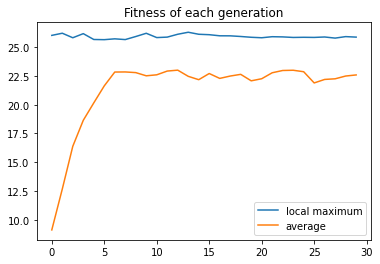

In [ ]:
# 定植日到採收日
TRAIN_SET = [plantDates, harvestDates]
genetic_algorithm(TRAIN_SET, generation_size=100, generation_limit=30)

  0%|          | 0/29 [00:00<?, ?it/s]

Global Max fitness: 10.866 [9.732292730290782, 18.792326034961846, 29.719489914067474, 29.97035712231292]
Last Max fitness: 10.68 [9.834175833347139, 18.94827132045128, 27.90221074846812, 30.629635066414075]


[9.732292730290782, 18.792326034961846, 29.719489914067474, 29.97035712231292]

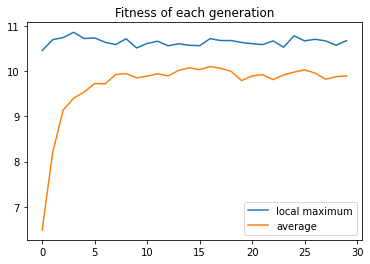

In [ ]:
# 開花日到採收日
TRAIN_SET = [bloomDates, harvestDates]
genetic_algorithm(TRAIN_SET, generation_size=100, generation_limit=30)